# Annotate IBEX image with TissueTag
In this notebook, we will use 2 channels from an IBEX protein multiplex imaging platform as a reference for annotations. 
We will load the image, then annotate it with a combinations of semi-automatic annotation and manual tools.
Annotations will be saved for consistency and easy loading in downstream steps.

In [ ]:
# initialisation 
import os
import panel as pn
import socket
import numpy as np
import tissue_tag as tt
import tissue_tag.annotation

os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "*"

pn.extension()

# Part 1 - Load image and define annotation names and colors 

(2704, 3948)


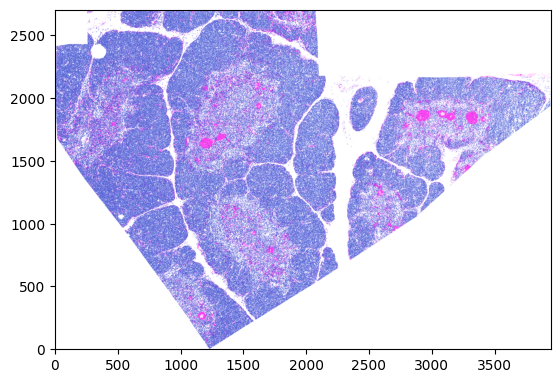

In [2]:
# here you can either read a single image (grayscale or RGB) or generate a virtual H&E from 2 images
Path = '../' #directory of tissuetag repo
path = Path + 'data/tissue_tag_minimal_example_ibex/' 
tt_object = tt.read_image(
    path=path+'Sample_05_THY45_Z5_ch0009.jpg', # nuclear
    contrast_factor=2,
    background_image_path=path+'Sample_05_THY45_Z5_ch0058.jpg', # panCK
    ppm_image=3.5198, 
    ppm_out=1,
)

In [3]:
# define tissue structures to annotate and colors.
annodict = {
    'Artifacts':'grey', 
    'Medulla':'green',
    'Cortex':'cyan',
    'Edge':'brown',
    'HS':'magenta',
    'Vessels':'blue',
    'PVS':'red',
    'Other':'orange',
}
tt_object.annotation_map = annodict

From here there are two options:

1. Provide initial training labels of specific areas on the image and automatically predict the pixel identity for the rest of the image with a random forest (RF) pixel classifier

2. Annotate the image manually and skip the RF classifier 



# Part 2 - Iterative annotation section

At this stage, you can choose whether to use datashader - `use_datashader=True` for rendering the image (recommended for large images/high-resolution annotation). While the annotation process is slower with datashader, loading would be reasonable. If the image is too large, without datashader, the image might not load or take an extremely long time to load. 

Annotation is done by creating convex shapes in single strokes, the pixels inside the convex region would be filled in the `update_annotator` step. it's recommended to use a mouse with a wheel for easy scrolling in and out.
*to remove a label the use can click on the label to remove and press the backspace key. 

In [ ]:
# use annotator to label tissue regions according to categories indicated above
annotator = tissue_tag.annotation.annotator(tt_object, use_datashader=True)
annotator.servable()

In [ ]:
tt_object.label_image.sum()

In [ ]:
# This step fills in the shapes created for the pixel classifier
tissue_tag.annotation.plot_labels(tt_object, alpha=0.5)

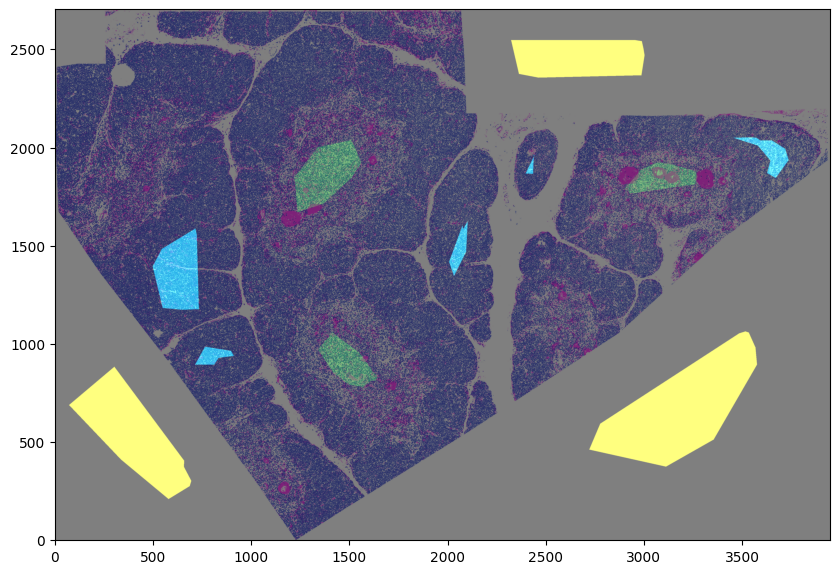

In [6]:
%%time
# Train and predict the image pixels with a random forest classifier. This step takes about 1 to 10 min depending on number of training areas and resolution  
tissue_tag.annotation.pixel_label_classifier(tt_object)

From this point go back to the annotator and correct annotations until happy with results. Do not rerun the classifier on the predicted image, if needed repeat the classification from the stage of initial training labels with changes. 

# Part 3 - Finalise annotations and save

In [ ]:
# plot result 
tissue_tag.annotation.plot_labels(tt_object, alpha=0.5)

#  Save annotations (and load)

In [ ]:
isExist = os.path.exists(path+'tissue_annotations')
if not(isExist):
    os.mkdir(path+'/tissue_annotations/')
    
tt_object.save_annotation(file_path=path+'/tissue_annotations/annotation_tissue.h5')

In [10]:
# optional - load annotations and as an intermediate step 
tt_object = tt.load_annotation(file_path=path + '/tissue_annotations/annotation_tissue.h5')

loaded image - size - (2704, 3948, 4)
loaded ppm
1
loaded label image - size - (2704, 3948)
loaded annotation map
{'unassigned': 'yellow', 'Artifacts': 'grey', 'Medulla': 'green', 'Cortex': 'cyan', 'Edge': 'brown', 'HS': 'magenta', 'Vessels': 'blue', 'PVS': 'red', 'Other': 'orange'}
